In [1]:
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

datafile='/pscratch/sd/d/dfarough/LargeScaleStructure/data/Uchuu1000-Pl18_z0p00_hlist_4.h5'

f_pos = h5py.File(datafile, 'r')
pos = np.stack([np.asarray(f_pos['x']),
                np.asarray(f_pos['y']),
                np.asarray(f_pos['z'])]).T

pos = torch.tensor(pos, dtype=torch.float32)

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import h5py

class UchuuVoxelizedData:
    def __init__(self, 
                 datafile='/pscratch/sd/d/dfarough/LargeScaleStructure/data/Uchuu1000-Pl18_z0p00_hlist_4.h5', 
                 box_size=36, 
                 voxel_size=10):

        print('INFO: fetching data from {} '.format(datafile))

        self.box_size = box_size
        self.voxel_size = voxel_size
        self.num_side = int(round(box_size / voxel_size)) 
        self.num_voxels = self.num_side ** 3   
        
        f_pos = h5py.File(datafile, 'r')
        pos = np.stack([np.asarray(f_pos['x']),
                        np.asarray(f_pos['y']),
                        np.asarray(f_pos['z'])]).T

        pos = torch.tensor(pos, dtype=torch.float32)
        mask = (pos[...,0] <= box_size) & (pos[...,1] <= box_size) & (pos[...,2] <= box_size)

        print('INFO: voxelizing {} points into {} voxels within box size {} Mpc'.format(mask.sum().item(), self.num_voxels,box_size))
        
        self.local_patches = self.build_voxel_grid(pos[mask])
        
    def sample(self, voxel_idx=0, normalize=False):
        start = self.offsets[voxel_idx]
        end = self.offsets[voxel_idx + 1]
        if normalize:
            return self.normalize_data(self.local_patches[start:end], voxel_idx) 
        return self.local_patches[start:end]

    def get_3D_coord(self, voxel_idx=0):
        z = voxel_idx // (self.num_side * self.num_side)
        y = (voxel_idx % (self.num_side * self.num_side)) // self.num_side
        x = voxel_idx % self.num_side
        return (x, y, z)

    def get_voxel_center(self, voxel_idx=0):
        x_idx, y_idx, z_idx = self.get_3D_coord(voxel_idx)
        center_x = (x_idx + 0.5) * self.voxel_size
        center_y = (y_idx + 0.5) * self.voxel_size
        center_z = (z_idx + 0.5) * self.voxel_size
        return (center_x, center_y, center_z)

    def normalize_data(self, points, voxel_idx=0):
        center_x, center_y, center_z = self.get_voxel_center(voxel_idx)
        shift = torch.tensor([center_x, center_y, center_z], dtype=points.dtype, device=points.device)
        scale = self.voxel_size / 2.0
        self.normalization_params = {'shift': shift, 'scale': scale}
        return (points - shift) / scale

    def build_voxel_grid(self, points):
        """
        points: (N, 3) tensor with coordinates in [0, box_size) in each dim.
        Returns:
            points_sorted : (N, 3) tensor, points sorted by voxel id
            offsets       : (n_voxels + 1,) long tensor; slice [offsets[v]:offsets[v+1]] gives
                            the rows in points_sorted that belong to voxel v
            n_side        : number of voxels per side (should be 50)
        """

        device = points.device
                  
        # Create bin boundaries for each dimension
        boundaries = torch.arange(self.num_side + 1, dtype=points.dtype, device=device) * self.voxel_size
        ix = torch.bucketize(points[:, 0], boundaries, right=False) - 1
        iy = torch.bucketize(points[:, 1], boundaries, right=False) - 1
        iz = torch.bucketize(points[:, 2], boundaries, right=False) - 1
        
        # Clamp to handle any points exactly at box_size 
        ix = ix.clamp(0, self.num_side - 1)
        iy = iy.clamp(0, self.num_side - 1) 
        iz = iz.clamp(0, self.num_side - 1)

        # Flatten 3D voxel index (ix, iy, iz) -> voxel_id
        voxel_ids = ix + self.num_side * (iy + self.num_side * iz)  # (N,)

        # Count how many points per voxel
        counts = torch.bincount(voxel_ids, minlength=self.num_voxels)

        # offsets[v]   = start index of voxel v in the sorted points array
        # offsets[v+1] = end index (exclusive)
        self.offsets = torch.zeros(self.num_voxels + 1, dtype=torch.long, device=device)
        self.offsets[1:] = torch.cumsum(counts, dim=0)

        # Sort points by voxel id so each voxel occupies a contiguous block
        order = torch.argsort(voxel_ids)
        points_sorted = points[order]

        return points_sorted

    def display(self, voxel_idx, normalize=False, figsize=(12, 6),  dpi=120, **kwargs):
        data = self.sample(voxel_idx, normalize).cpu().numpy()
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(data[:,0], data[:,1], data[:,2], **kwargs)
        plt.show()
        



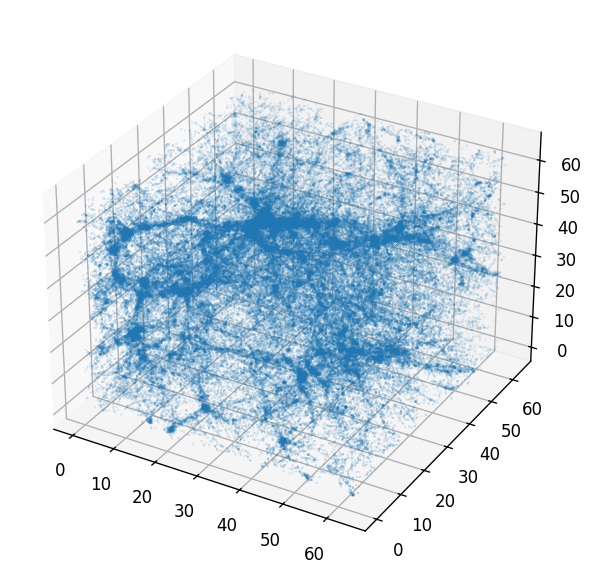

In [13]:
data.display(voxel_idx=0, s=0.01)

In [10]:
data = UchuuVoxelizedData(box_size=128, voxel_size=64)

INFO: fetching data from /pscratch/sd/d/dfarough/LargeScaleStructure/data/Uchuu1000-Pl18_z0p00_hlist_4.h5 
INFO: voxelizing 1071151 points into 8 voxels within box size 128 Mpc
INFO: voxelizing 1071151 points into 8 voxels within box size 128 Mpc


In [12]:
data.sample(voxel_idx=0, normalize=True).shape

torch.Size([153155, 3])

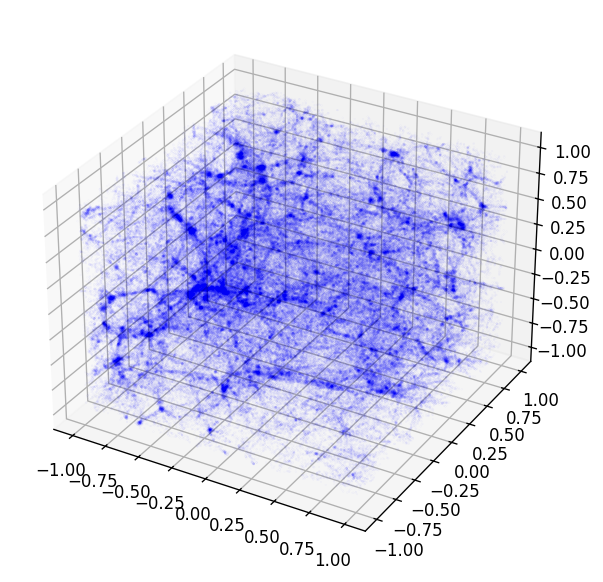

In [11]:
data.display(0, normalize=True, s=0.001, alpha=0.25, c='b')

In [32]:
class Uniform3D:
    def __init__(self, support='ball'):
        self.support = support
        
    def sample(self, num_points=10_000):
        if self.support == 'ball':
            return self.uniform_ball(num_points)
        elif self.support == 'cube':
            return torch.distributions.uniform.Uniform(low=-1, high=1).sample((num_points,3))

    def uniform_ball(self, num_points=10_000, R=1):
        m_costheta = torch.distributions.uniform.Uniform(low=-1, high=1)
        m_phi = torch.distributions.uniform.Uniform(low=0, high=2*np.pi)
        radius = torch.ones(num_points) * R
        costheta = m_costheta.sample((num_points,))
        sintheta = torch.sqrt(1 - costheta**2)
        phi = m_phi.sample((num_points,))
        x = radius * sintheta * torch.cos(phi)
        y = radius * sintheta * torch.sin(phi)
        z = radius * costheta
        pos = torch.stack([x,y,z]).T
        return pos.to(torch.float32)

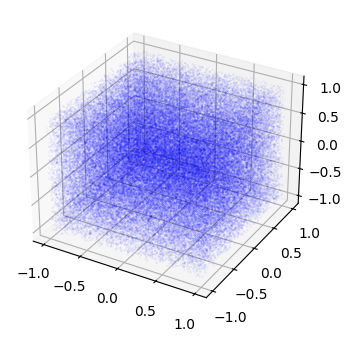

In [41]:
uniform = Uniform3D(support='cube')
data = uniform.sample(100000)

fig = plt.figure(figsize=(4,4), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2], s=0.01, alpha=0.25, c='b')
plt.show()
        

In [73]:
voxel_data = []
multiplicities = []

# First pass: collect all voxels and their sizes
for v in range(len(offsets)-1):
    voxel_points = get_voxel_points(points_sorted, offsets, v)
    voxel_data.append(voxel_points)
    multiplicities.append(voxel_points.shape[0])

multiplicities = torch.tensor(multiplicities, dtype=torch.float32)
multiplicities.min(), multiplicities.max(), multiplicities.mean(), multiplicities.std()


(tensor(0.), tensor(5794.), tensor(258.2857), tensor(238.0942))

In [ ]:
voxel_data = torch.stack(voxel_data, dim=0)  # (n_voxels, max_points_per_voxel, 3)

/tmp/ipykernel_2071583/342606177.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  multiplicities = torch.tensor(multiplicities, dtype=torch.float32)


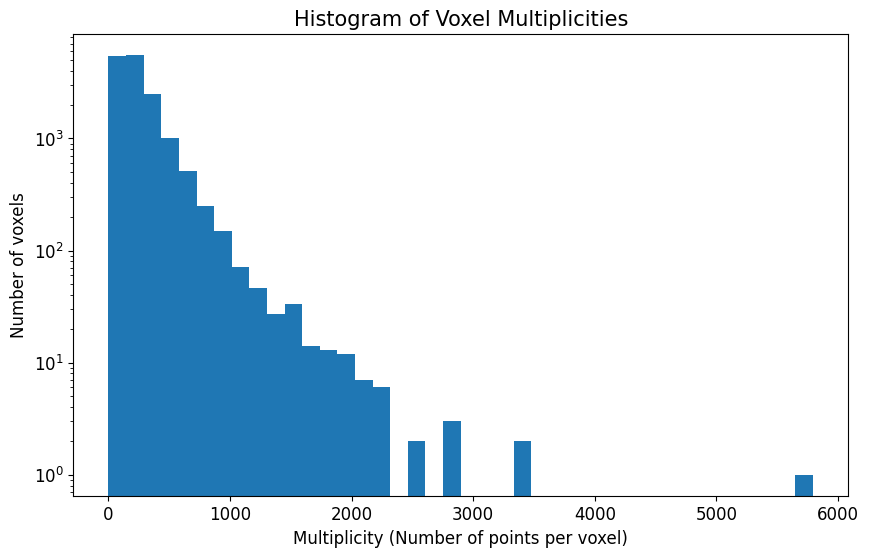

In [74]:
multiplicities = torch.tensor(multiplicities, dtype=torch.float32)
multiplicities.min(), multiplicities.max(), multiplicities.mean(), multiplicities.std()

plt.hist(multiplicities.numpy(), bins=40)
plt.yscale('log')
plt.xlabel('Multiplicity (Number of points per voxel)')
plt.ylabel('Number of voxels')
plt.title('Histogram of Voxel Multiplicities')
plt.show()

In [64]:
# Get the index of the voxel with maximum multiplicity
max_idx = torch.argmax(multiplicities)
print(f"Voxel with maximum multiplicity: index {max_idx}, count = {multiplicities[max_idx]}")

# Convert voxel index back to 3D coordinates to see where it is
ix = max_idx % n_side
iy = (max_idx // n_side) % n_side  
iz = max_idx // (n_side ** 2)
print(f"3D voxel coordinates: ({ix}, {iy}, {iz})")
print(f"This is at the boundary: x={ix==0 or ix==n_side-1}, y={iy==0 or iy==n_side-1}, z={iz==0 or iz==n_side-1}")

Voxel with maximum multiplicity: index 8808, count = 6212.0
3D voxel coordinates: (8, 2, 14)
This is at the boundary: x=False, y=False, z=False


In [47]:
100 **3

1000000

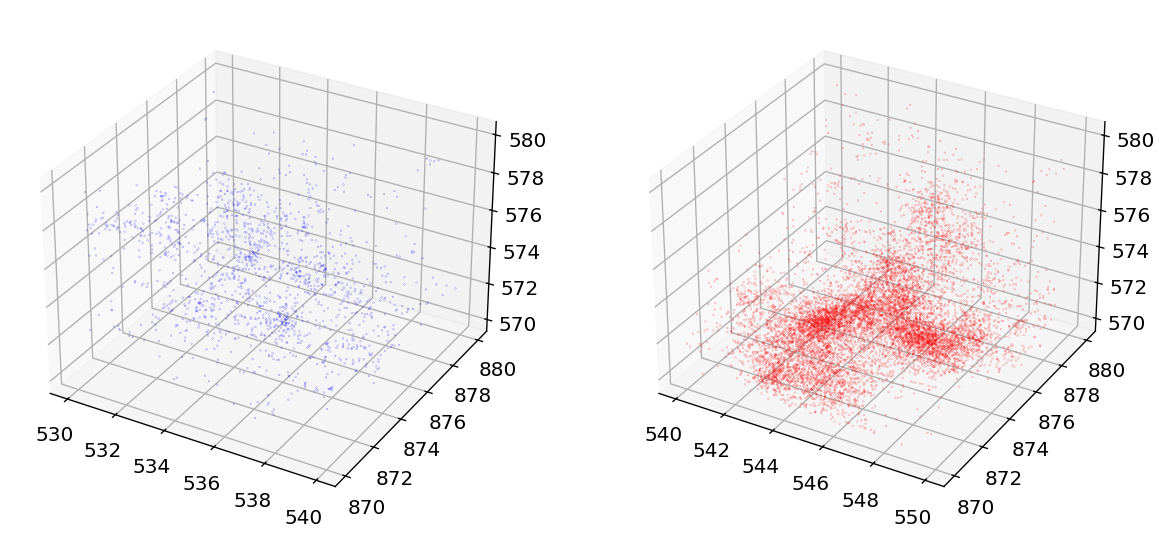

In [ ]:
from utils.plotting import plot_lss_results

N=578753

plot_lss_results(pos[N], [N+1])

In [40]:
1000/20

50.0

In [ ]:
k, PK_uchuu = compute_power_spectrum(voxel_points.numpy(), box_size=200.0, grid_size=1024)

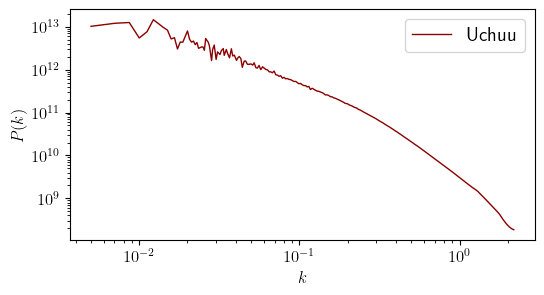

In [ ]:
from matplotlib import rcParams
import matplotlib as mpl
import numpy as np  
import torch
import matplotlib.pyplot as plt

rcParams.update({'figure.autolayout': True})
mpl.rc('axes',edgecolor='k')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
# Disable LaTeX rendering - comment out the next line if LaTeX is not available
# plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(6,3)) 
plt.loglog(k, PK_uchuu, label='Uchuu', c='darkred', lw=1.) 
plt.xlabel("k") 
plt.ylabel("P(k)") 
# plt.xlim(0.01, 0.1)
plt.ylim(1e12, 1e20)
plt.legend() 
plt.show()